In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Directory containing all your images
data_dir = 'D:\Studies\M1 ISII S2\Data Mining\External_Dataset\Dataset'
batch_size = 32
image_size = (128, 128)

In [3]:
#Total number of images in the dataset
total_images = sum([len(files) for r, d, files in os.walk(data_dir)])
print(f"Total number of images in the dataset: {total_images}")

Total number of images in the dataset: 29797


In [4]:
# Load the data using image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode= 'categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
)

Found 29797 files belonging to 64 classes.


In [5]:

# Load the dataset from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation and testing
    subset="training",
    seed=123,  # Set seed for reproducibility
    image_size=image_size,
    batch_size=batch_size
)

# Split the remaining 20% into validation and testing sets (50:50 split)
validation_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% of the original dataset
    subset="validation",
    seed=123,  # Same seed as training
    image_size=image_size,
    batch_size=batch_size
)

# Split the validation_test_dataset into validation and testing sets
validation_size = int(0.5 * len(validation_test_dataset))
test_size = validation_size

validation_data = validation_test_dataset.take(validation_size)
test_data = validation_test_dataset.skip(validation_size)

# Print the class names
class_names = train_dataset.class_names
print(class_names)

# Print the number of batches in the training set
print(f"Number of batches in the training set: {len(train_dataset)}")

# Print the number of batches in the validation set
print(f"Number of batches in the validation set: {len(validation_data)}")

# Print the number of batches in the testing set
print(f"Number of batches in the testing set: {len(test_data)}")

# Print the number of images in the training set
print(f"Number of images in the training set: {len(train_dataset) * batch_size}")

# Print the number of images in the validation set
print(f"Number of images in the validation set: {len(validation_data) * batch_size}")

# Print the number of images in the testing set
print(f"Number of images in the testing set: {len(test_data) * batch_size}")

# Print number of classes
print(f"Number of classes: {len(class_names)}")



Found 29797 files belonging to 64 classes.
Using 23838 files for training.
Found 29797 files belonging to 64 classes.
Using 5959 files for validation.
['Ain_End', 'Ain_Middle', 'Ain_Start', 'Alf_End', 'Baa_End', 'Baa_Middle', 'Baa_Start', 'Daad_End', 'Daad_Middle', 'Daad_Start', 'Dal_End', 'Dhadh_End', 'Faa_End', 'Faa_Middle', 'Faa_Start', 'Gem_End', 'Gem_Start', 'Gen_End', 'Gen_Middle', 'Ha_End', 'Ha_Middle', 'Ha_Start', 'Haa_End', 'Haa_Start', 'Kaf_End', 'Kaf_Middle', 'Kaf_Start', 'Khaa_End', 'Khaa_Start', 'Lam_Alf_End', 'Lam_End', 'Lam_Middle', 'Lam_Start', 'Mem_End', 'Mem_Start', 'Non_End', 'Non_Middle', 'Non_Start', 'Qaf_End', 'Qaf_Middle', 'Qaf_Start', 'Raa_End', 'Saad_End', 'Saad_Middle', 'Saad_Start', 'Shen_End', 'Shen_Middle', 'Shen_Start', 'Sin_End', 'Sin_Middle', 'Sin_Start', 'Taa_End', 'Taa_Middle', 'Taa_Start', 'Tah_Middle', 'Thaa_End', 'Thaa_Middle', 'Thaa_Start', 'Waw_End', 'Yaa_End', 'Yaa_Middle', 'Yaa_Start', 'Zal_End', 'Zin_End']
Number of batches in the training set:

In [6]:
# Convert integer labels to one-hot encoded vectors
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))
validation_dataset = validation_data.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))
test_dataset = test_data.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))


In [7]:
# Print the shape of the image
for image_batch, labels_batch in train_dataset:
    print(f"Training image batch shape: {image_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break
print("------------------------------------------------------------------------")
for image_batch, labels_batch in validation_dataset:
    print(f"Validation image batch shape: {image_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break
print("------------------------------------------------------------------------")
for image_batch, labels_batch in test_dataset:
    print(f"Test image batch shape: {image_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break

Training image batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 64)
------------------------------------------------------------------------
Validation image batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 64)
------------------------------------------------------------------------
Test image batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 64)


In [8]:
def display_nine_images(dataset):
    plt.figure(figsize=(6, 6))

    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            # Find index of non-zero value in one-hot encoded label
            class_index = np.argmax(labels[i])

            plt.title(f"Class: {class_names[class_index]}")
            plt.axis("off")
    plt.show()

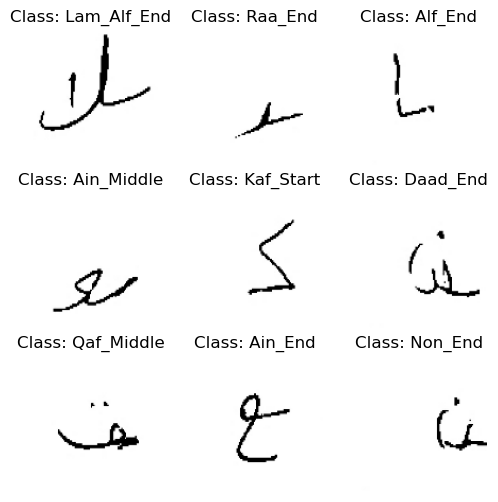

In [9]:
display_nine_images(train_dataset)

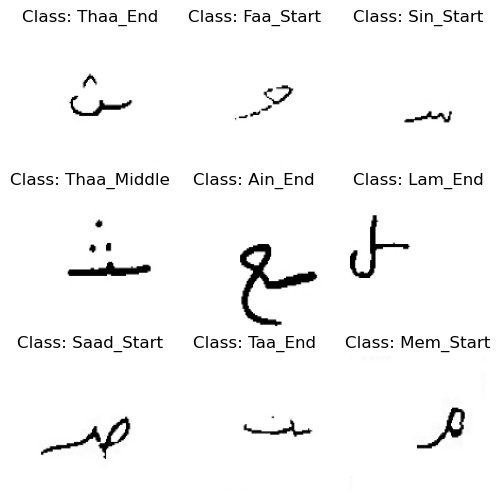

In [10]:
display_nine_images(test_dataset)

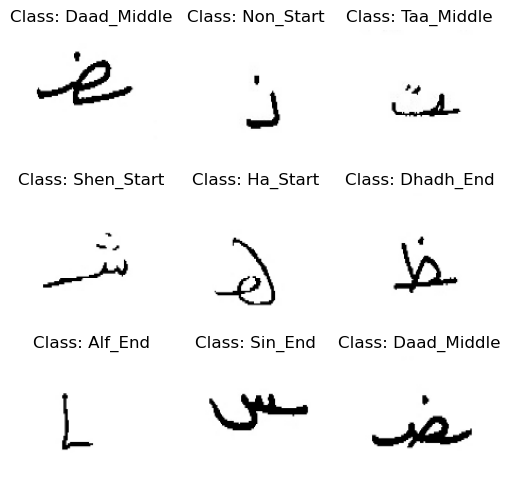

In [11]:
display_nine_images(validation_dataset)

In [12]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

# Define a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

# Load pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[lr_scheduler]
)


Epoch 1/10
745/745 [==============================] - 210s 278ms/step - loss: 2.2122 - accuracy: 0.4268 - val_loss: 1.6353 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 2/10
745/745 [==============================] - 201s 270ms/step - loss: 1.3501 - accuracy: 0.6266 - val_loss: 1.3335 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 3/10
745/745 [==============================] - 197s 264ms/step - loss: 1.1036 - accuracy: 0.6918 - val_loss: 1.2467 - val_accuracy: 0.6405 - lr: 0.0010
Epoch 4/10
745/745 [==============================] - 203s 272ms/step - loss: 0.9661 - accuracy: 0.7262 - val_loss: 1.1742 - val_accuracy: 0.6526 - lr: 0.0010
Epoch 5/10
745/745 [==============================] - 207s 278ms/step - loss: 0.8605 - accuracy: 0.7530 - val_loss: 1.0788 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 6/10
745/745 [==============================] - 206s 277ms/step - loss: 0.7756 - accuracy: 0.7815 - val_loss: 1.0846 - val_accuracy: 0.6892 - lr: 0.0010
Epoch 7/10
745/745 [==========================

In [13]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
Total params: 23,718,848
Trainable params: 131,136
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Saving the history of the model
import pickle
with open('D:\Studies\M1 ISII S2\Data Mining\history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [14]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f'\nTest accuracy: {test_acc}')

94/94 - 22s - loss: 0.9947 - accuracy: 0.7030 - 22s/epoch - 235ms/step

Test accuracy: 0.702983558177948


In [24]:
val_loss, val_acc = model.evaluate(validation_dataset, verbose=2)
print(f'\nValidation accuracy: {val_acc}')

93/93 - 20s - loss: 0.9918 - accuracy: 0.7030 - 20s/epoch - 217ms/step

Validation accuracy: 0.7029569745063782


In [15]:
# Save the model
model.save('D:\Studies\M1 ISII S2\Data Mining\my_model.h5')

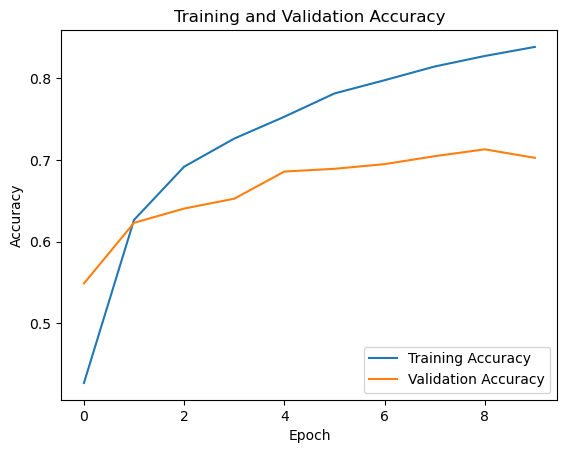

In [20]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

1/1 [==============================] - 0s 209ms/step


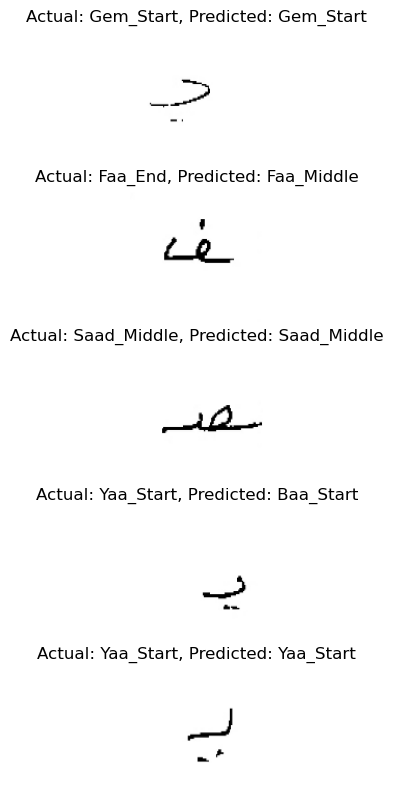

In [27]:
# Predictions
# pick 5 random images from the test dataset in one plot fig and showing the actual class of the image and the predicted class

# Get the class names
class_names = dataset.class_names

# Get the test images and labels
test_images, test_labels = next(iter(test_dataset))

# Get the predictions
predictions = model.predict(test_images)

# Plot the images with the actual and predicted class
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    actual_class = class_names[np.argmax(test_labels[i])]
    predicted_class = class_names[np.argmax(predictions[i])]
    plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}")
    plt.axis("off")
plt.show()
